# (19) df: lca inference

**Motivation**: Device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def sc_extract_info(fname: str):
    info = fname.split('_')
    type, lamb, iter = info[:3]
    vae_name = '_'.join(info[3:]).replace('.npz', '')
    vae_type = vae_name.split('-')[0]
    if 'relu' in vae_name:
        vae_type = f"{vae_type}-relu"
    elif 'exp' in vae_name:
        vae_type = f"{vae_type}-exp"
    if type == 'fista':
        type = 'ista'
    info = dict(
        type=str(type),
        vae_type=vae_type,
        iter=int(iter.split('-')[1]),
        lamb=float(lamb.split('-')[-1]),
        vae_source=vae_name,
    )
    return info


def analyze_fits_sc(fits: str):
    df_sc = collections.defaultdict(list)
    for fname in tqdm(fits, ncols=60):
        vals = sc_extract_info(fname)
        # load
        try:
            run = np.load(pjoin(root[vals['type']], fname))
        except:
            print(f"bad: {fname}")
        y, z = run['recons'], run['activations']
        # recon
        vals['mse_map'] = tr.model.loss_recon(
            y=tr.to(y.reshape(-1, 1, 16, 16)),
            x=tr.dl_vld.dataset.tensors[0],
        ).mean().item()
        # sparse score
        lifetime, population, _ = sparse_score(
            z.astype('float32'))
        vals['lifetime'] = lifetime.mean()
        vals['population'] = population.mean()
        # add values
        for k, v in vals.items():
            df_sc[k].append(v)
    
    df_sc = pd.DataFrame(df_sc)
    return df_sc

## Device

In [3]:
device_idx = 3
device = f'cuda:{device_idx}'

from analysis.final import sort_fits, analyze_fits

## vld data

In [4]:
tr = TrainerVAE(
    MODEL_CLASSES['poisson'](CFG_CLASSES['poisson'](dataset='DOVES', save=False)),
    ConfigTrainVAE(),
    device=device,
)

## Load SC results

In [5]:
root = {
    'lca': add_home('Dropbox/chkpts/lca_inference'),
    # 'ista': add_home('Dropbox/chkpts/ISTA'),
}
print({
    k: len(os.listdir(v)) for
    k, v in root.items()
})

{'lca': 720}

### Get both + concat + save

In [6]:
fits_lca = sorted(os.listdir(root['lca']))
# fits_ista = sorted(os.listdir(root['ista']))

In [7]:
# df_inference_sc = pd.concat([
#     analyze_fits_sc(fits_lca),
#     # analyze_fits_sc(fits_ista),
# ]).reset_index(drop=True)

df_lca_inf = analyze_fits_sc(fits_lca)

save_obj(
    obj=df_lca_inf,
    file_name='df_lca_inf',
    save_dir=tmp_dir,
    verbose=True,
    mode='df',
)

100%|█████████████████████| 720/720 [03:52<00:00,  3.09it/s]


[PROGRESS] 'df_lca_inf.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [8]:
df_lca_inf['lamb'].value_counts()

lamb
0.001    90
0.005    90
0.010    90
0.050    90
0.100    90
0.500    90
0.700    90
1.000    90
Name: count, dtype: int64

In [9]:
df_lca_inf['iter'].value_counts()

iter
100    240
500    240
900    240
Name: count, dtype: int64

## Load df, analyze

In [11]:
df_lca_inf = pjoin(tmp_dir, 'df_lca_inf.df')
df_lca_inf = pd.read_pickle(df_lca_inf)

In [12]:
df_lca_inf

,type,vae_type,iter,lamb,vae_source,mse_map,lifetime,population
0,lca,categorical,100,0.001,categorical-<conv+b|lin>-DOVES-mc_solo-1_(2024...,133.146698,0.979408,0.978782
1,lca,categorical,100,0.001,categorical-<conv+b|lin>-DOVES-mc_solo-2_(2024...,132.758667,0.979385,0.978666
2,lca,categorical,100,0.001,categorical-<conv+b|lin>-DOVES-mc_solo-3_(2024...,133.598450,0.980079,0.979335
3,lca,categorical,100,0.001,categorical-<conv+b|lin>-DOVES-mc_solo-4_(2024...,132.415878,0.979520,0.978783
4,lca,categorical,100,0.001,categorical-<conv+b|lin>-DOVES-mc_solo-5_(2024...,133.298325,0.980077,0.979289
...,...,...,...,...,...,...,...,...
715,lca,poisson,900,1.000,poisson-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_...,82.948410,0.954057,0.954043
716,lca,poisson,900,1.000,poisson-<conv+b|lin>-DOVES-mc_solo-2_(2024_05_...,83.970329,0.954645,0.954953
717,lca,poisson,900,1.000,poisson-<conv+b|lin>-DOVES-mc_solo-3_(2024_05_...,83.355659,0.954292,0.954237
718,lca,poisson,900,1.000,poisson-<conv+b|lin>-DOVES-mc_solo-4_(2024_05_...,83.000916,0.954302,0.954078


In [13]:
df_lca_inf['vae_type'].value_counts()

vae_type
categorical      120
gaussian-exp     120
gaussian-relu    120
gaussian         120
laplace          120
poisson          120
Name: count, dtype: int64

<Axes: xlabel='mse_map', ylabel='lifetime'>

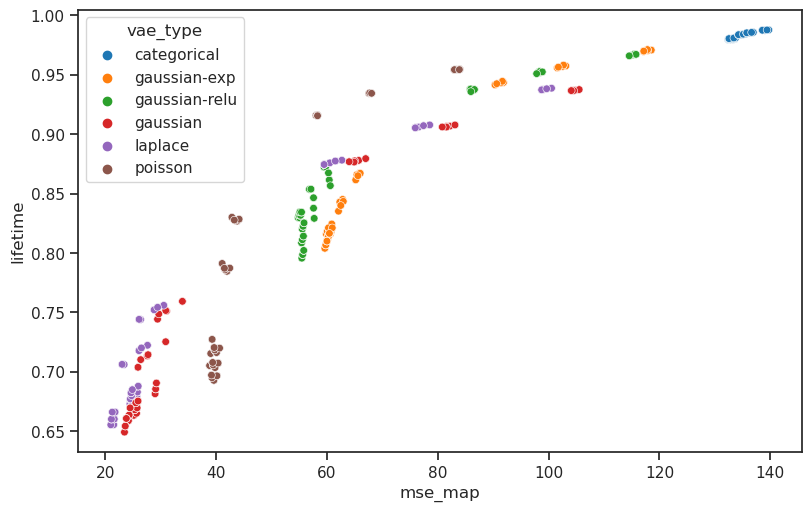

In [15]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(data=df_lca_inf, x='mse_map', y='lifetime', hue='vae_type', s=30)

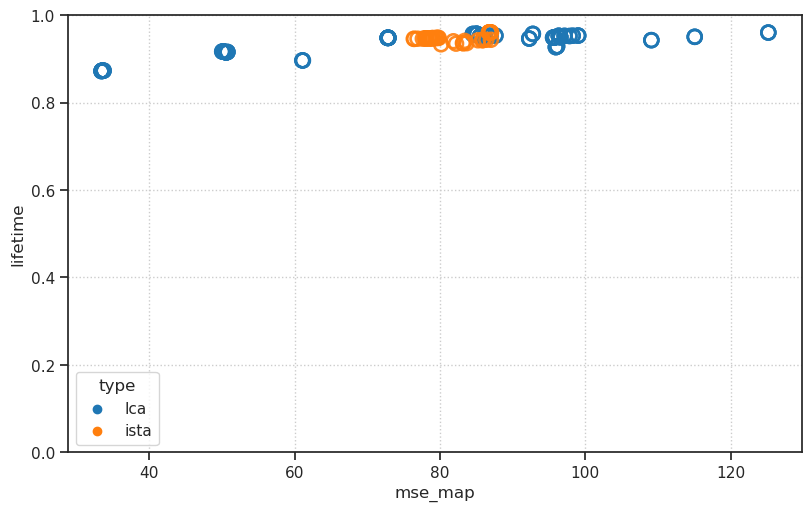

In [13]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(
    data=df_sc.loc[df_sc['quality'] == 'good'],
    x='mse_map', y='lifetime', hue='type',
    s=100, alpha=0.9,
)
for artist in ax.collections:
    c = artist.get_facecolor()
    artist.set_edgecolor(c)
    artist.set_facecolor('none')
    artist.set_lw(1.9)
ax.set(ylim=(0, 1))
ax.grid()
plt.show()

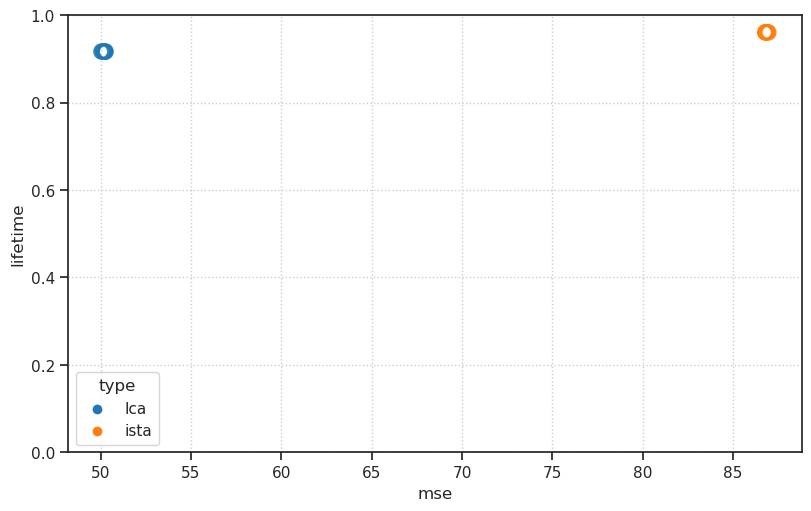

In [15]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(
    data=df_sc.loc[df_sc['quality'] == 'best'],
    x='mse', y='lifetime', hue='type',
    s=100, alpha=0.9,
)
for artist in ax.collections:
    c = artist.get_facecolor()
    artist.set_edgecolor(c)
    artist.set_facecolor('none')
    artist.set_lw(1.9)
ax.set(ylim=(0, 1))
ax.grid()
plt.show()